In [25]:
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "..\\scripts\\")
import test
sys.path.insert(0, "..\\scripts\\")
import taxis_analysis_function as MyFn


if "__main__" == __name__:
    df = MyFn.load_dataset()
    
    distance_profit_analysis = (df.pipe(MyFn.distance_group_column)
    .pipe(MyFn.calculate_work_hours)
    .pipe(MyFn.calculate_gasoline_consumption)
    .pipe(MyFn.calculate_auto_utilization)
    .pipe(MyFn.group_by_distance)
    .pipe(MyFn.calculate_total_profit)
    .pipe(MyFn.calculate_profit_by_hour)
    )

In [26]:
distance_profit_analysis

,distance_group,count_summons,dist_avg,dist_total,dist_min,dist_max,fare,tips,tolls,gas_expense,auto_utilization_cost,hours_sum,total,profit_per_hour
0,short,5422,1.723670,9345.74,0.01,5.0,50551.21,8513.38,48.50,654.2018,2009.3341,999.317222,56352.5541,56.391057
1,medium,776,8.504639,6599.60,5.01,15.0,22360.92,2877.87,1192.32,461.9720,1418.9140,390.609167,22165.5840,56.746195
2,long,184,19.087065,3512.02,15.01,36.7,10258.54,1211.74,819.14,245.8414,755.0843,146.400278,9650.2143,65.916639


Hypotesis: Passengers leave more tips when paying in cash than card

result: Does not leave a tip in cash

Calculate corelation beetwen tips and distance

In [27]:
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt


def load_dataset():
    return sns.load_dataset("taxis")

def get_date_parameters(df:pd.DataFrame) -> pd.to_datetime:
    
        min_date = df['pickup'].min()
        max_date = df['pickup'].max()
        
        return min_date, max_date
    
def filtered_by_date(df:pd.DataFrame, date_range:tuple = ()) -> pd.DataFrame:
    """filtered df by date 
    min date: 2019-02-28
    max date: 2019-03-31
    Args:
        df (pd.DataFrame): df
        date_range (tuple): ('start_date': yyyy-mm-dd, 'end_date': yyyy-mm-dd). Default date_range = ()
    Returns:
        pd.DataFrame: new dataframe
    """
    if date_range == ():
        return df
    else:
        start_date = date_range[0]
        end_date = date_range[1]
        dt_range = (df['pickup'] >= start_date) & (df['pickup'] <= end_date)
        filtered_df = df.loc[dt_range]
        return filtered_df

def distance_group_column(df: pd.DataFrame)-> pd.DataFrame:
    "returned new column with distance group names"
    
    df['distance_group'] = pd.cut(df['distance'], bins=[0, 5, 15, float("inf")], labels=['short', 'medium', 'long'])
    
    return df

def calculate_gasoline_consumption(df: pd.DataFrame, gasoline_consuption = 5, gasoline_price = 1.4)-> pd.DataFrame:
    "calculate gasoline consuption cost"
    return df.assign(gas_expense = lambda x: gasoline_consuption * x['distance']/100*gasoline_price)
  
    
def calculate_auto_utilization(df: pd.DataFrame)->pd.DataFrame:
    "calculate auto utilization cost"
    auto_utilization_cost = 215
    df = df.assign(utilization_cost = lambda x: auto_utilization_cost * x['distance']/1000)
    return df

def group_by_distance(df: pd.DataFrame) -> pd.DataFrame:
    """group by distance and calculate profit"""
    df = df.groupby(['distance_group'], as_index= False ).agg(
            count_summons = ('pickup','count'),
            dist_avg = ('distance','mean'),
            dist_total = ('distance','sum'),
            dist_min = ('distance', 'min'),
            dist_max = ('distance', 'max'),
           fare = ('fare','sum'),
           tips = ('tip', 'sum'),
           tolls = ('tolls', 'sum'),
           gas_expense = ('gas_expense', 'sum'),
           auto_utilization_cost = ('utilization_cost', 'sum'),
           hours_sum = ('work_hours','sum')
        )
    return df  

def calculate_work_hours(df: pd.DataFrame)-> pd.DataFrame:
    
    return (df.assign(date_diff = lambda x: x['dropoff'] - x['pickup'])
            .assign(work_hours = lambda x: x['date_diff'].dt.total_seconds() / 60 / 60))
    
   
def calculate_profit_by_hour(df: pd.DataFrame)-> pd.DataFrame:
    df = df.assign(profit_per_hour = lambda x: x['total']/x['hours_sum'])
    
    return df
    
def calculate_total_profit(df: pd.DataFrame)->pd.DataFrame:
    "Get total profit"
    df = df.assign(total = lambda x: sum([x['fare'],x['tips']-sum([x['tolls'],x['gas_expense'],x['auto_utilization_cost']])]))
    return df



def add_week_day(df:pd.DataFrame)->pd.DataFrame:
    df = df.assign(week_day = lambda x: x['pickup'].dt.day_name())
    return df


def get_time_groups(df:pd.DataFrame) -> pd.DataFrame:
    
    labels = []
    for i in range(0, 24, 3):
        time_label = '{:02d}-{:02d}'.format(i, i+3)
        labels.append(time_label)
    
    df['pickup_temp'] = pd.to_datetime(df['pickup'] + pd.Timedelta(hours=1))
    df['3h_interval'] = pd.cut(df['pickup_temp'].dt.hour, 
        bins=list(range(0, 25, 3)),
        labels=labels)
    df = df.drop(columns='pickup_temp')
    
    return df

def group_by_time_weekdays(df:pd.DataFrame) -> pd.DataFrame:
    df = df.groupby(['week_day','3h_interval'], as_index= False).sum(numeric_only = True)
    return df

def create_pivot_table(df:pd.DataFrame, values:str, index='week_day', columns='3h_interval') -> pd.DataFrame:
    weeks_labels = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    return pd.pivot_table(df, values=values, index=index, columns=columns).reindex(weeks_labels)
    
def visual_hot_map(df:pd.DataFrame, title:str, **kwargs) -> sns.heatmap:
    
    ax = sns.heatmap(df,cmap='coolwarm',linecolor='black',linewidth=1, **kwargs)
    ax.set_title(title, fontsize=18)
    
    return ax

def calculate_passengers_fare_index(df: pd.DataFrame) -> pd.DataFrame:
    return df.assign(profit_by_passenger = lambda x: x['fare']/x['passengers'])
    
    
def visualisation(df:pd.DataFrame, by:str, visual:bool = True, **kwargs)-> sns.heatmap or pd.DataFrame:
    """get table or heatmap by passengers, fare, profit_by_passenger, tip
    Args:
        df (pd.DataFrame): df
        by (str):  passengers, fare, profit_by_passenger, tip
        visual (bool, optional): True: get sns.heatmap 
                                False: get pd.DataFrame. Defaults to True.
        kwargs: sns.heatmap parameters

    Returns:
        sns.heatmap or pd.DataFrame: _description_
    """
    pivot = create_pivot_table(df, values=by)
    if visual: 
        visualisation_1 = visual_hot_map(pivot, title=f'by_{by}', **kwargs)
        return visualisation_1
    else:
        return pivot
    
def get_tips_sum(df: pd.DataFrame):
    return df.agg(
    tip_sum_by_cash=('tip', lambda x: x[df['payment'] == 'cash'].sum()),
    tip_sum_by_card=('tip', lambda x: x[df['payment'] == 'credit card'].sum())
    )
    
def get_pick_up_zone_by_card(df: pd.DataFrame):
    return df.loc[df['payment']=='credit card']


In [31]:
df = load_dataset()
df = filtered_by_date(df, date_range=('2019-03-15','2019-03-31'))
#2019-02-28
#2019-03-31
general_dataframe = (df.pipe(add_week_day)
.pipe(get_time_groups)
.pipe(group_by_time_weekdays)
.pipe(calculate_passengers_fare_index)
)

In [34]:
visualisation(general_dataframe, by = 'passengers', visual=False)

3h_interval,00-03,03-06,06-09,09-12,12-15,15-18,18-21,21-24
week_day,,,,,,,,
Monday,11,7,62,67,74,94,85,87
Tuesday,13,19,63,88,95,89,106,54
Wednesday,37,7,75,128,123,101,158,76
Thursday,36,13,77,72,89,82,151,96
Friday,56,29,150,113,119,146,164,107
Saturday,129,43,60,160,192,134,172,87
Sunday,53,24,31,70,85,97,103,50


<AxesSubplot:title={'center':'by_passengers'}, xlabel='3h_interval', ylabel='week_day'>

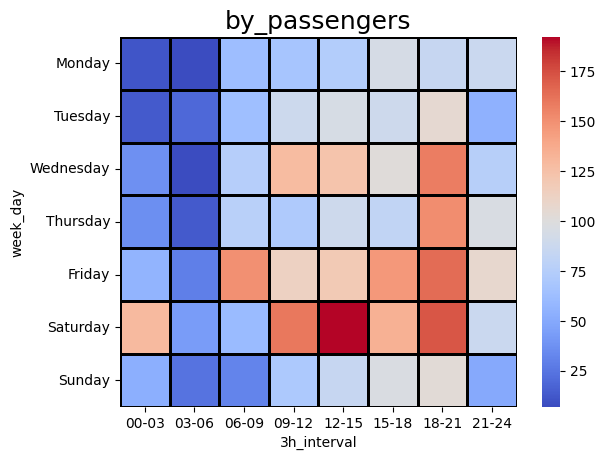

In [35]:
visualisation(general_dataframe, by = 'passengers', visual=True)